In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score


In [3]:
df = pd.read_csv("Algerian_forest_fires_cleaned.csv")
print("Shape:", df.shape)
print(df.info())
print(df.describe())


Shape: (243, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          243 non-null    int64  
 1   month        243 non-null    int64  
 2   year         243 non-null    int64  
 3   Temperature  243 non-null    int64  
 4   RH           243 non-null    int64  
 5   Ws           243 non-null    int64  
 6   Rain         243 non-null    float64
 7   FFMC         243 non-null    float64
 8   DMC          243 non-null    float64
 9   DC           243 non-null    float64
 10  ISI          243 non-null    float64
 11  BUI          243 non-null    float64
 12  FWI          243 non-null    float64
 13  Classes      243 non-null    object 
 14  Region       243 non-null    int64  
dtypes: float64(7), int64(7), object(1)
memory usage: 28.6+ KB
None
              day       month    year  Temperature          RH          Ws  \
count  243.000000 

In [4]:
# Drop date columns not useful for prediction
df.drop(columns=['day', 'month', 'year'], inplace=True)

# Convert categorical labels to binary
df['Fire'] = df['Classes'].apply(lambda x: 1 if x.strip().lower() == 'fire' else 0)
df.drop(columns=['Classes'], inplace=True)

# Handle any anomalies or duplicates
df.drop_duplicates(inplace=True)

# Feature Engineering: create interaction term
df['Temp_RH'] = df['Temperature'] * df['RH']

# Select numeric features for regression
features = ['Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'Region', 'Temp_RH']
X = df[features]
y = df['FWI']


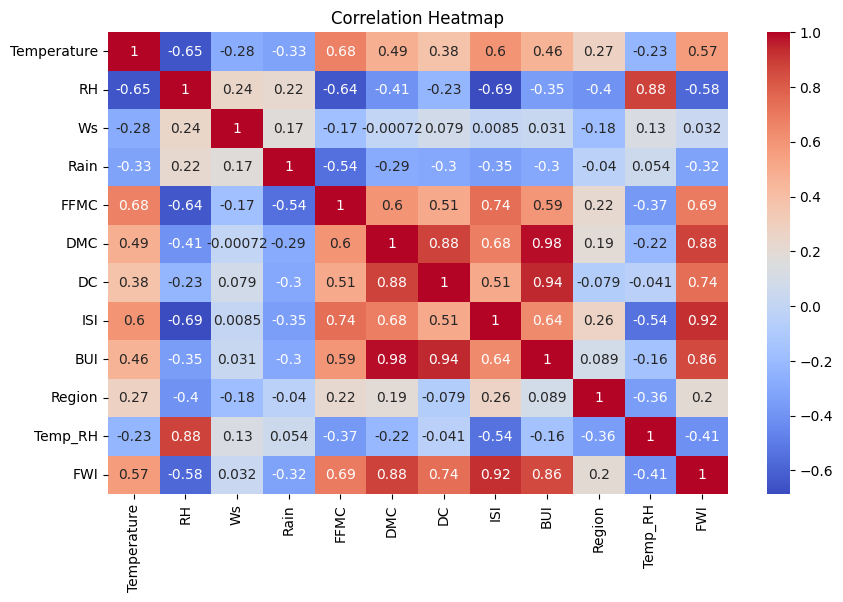

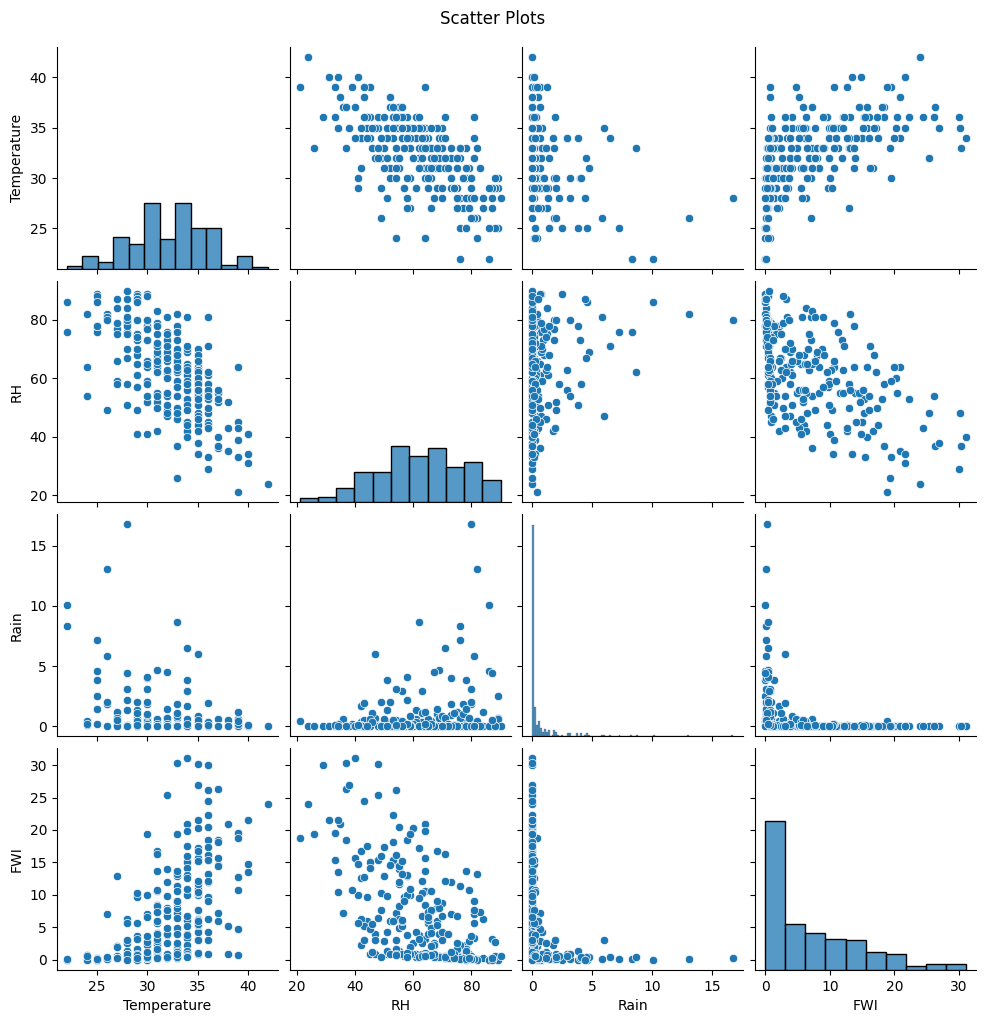

In [5]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[features + ['FWI']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Scatterplot matrix
sns.pairplot(df[['Temperature', 'RH', 'Rain', 'FWI']])
plt.suptitle("Scatter Plots", y=1.02)
plt.show()


In [6]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train base model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Linear Regression Test MSE: {mse:.2f}")
print(f"Linear Regression Test R²: {r2:.2f}")


Linear Regression Test MSE: 0.36
Linear Regression Test R²: 0.99


In [9]:
# Cross-validation
cv_scores = cross_val_score(lr, X, y, cv=5, scoring='r2')
print("Cross-validated R² scores:", cv_scores)
print("Average R²:", np.mean(cv_scores))

# Ridge and Lasso Regression with GridSearch
ridge = Ridge()
lasso = Lasso()

param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_cv = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
lasso_cv = GridSearchCV(lasso, param_grid, cv=5, scoring='r2')

ridge_cv.fit(X_train, y_train)
lasso_cv.fit(X_train, y_train)


Cross-validated R² scores: [0.98298051 0.9621088  0.97671074 0.84812436 0.97692617]
Average R²: 0.9493701133445575


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.254e+02, tolerance: 9.104e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.071e+02, tolerance: 9.264e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.691e+01, tolerance: 9.824e

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]}, scoring='r2')

In [10]:
print("Best Ridge alpha:", ridge_cv.best_params_)
print("Best Lasso alpha:", lasso_cv.best_params_)

ridge_r2 = r2_score(y_test, ridge_cv.predict(X_test))
lasso_r2 = r2_score(y_test, lasso_cv.predict(X_test))

print(f"Ridge R²: {ridge_r2:.2f}")
print(f"Lasso R²: {lasso_r2:.2f}")


Best Ridge alpha: {'alpha': 100}
Best Lasso alpha: {'alpha': 0.1}
Ridge R²: 0.98
Lasso R²: 0.99
